# Adversarial Networks Survey

This is the experiment to see the accuracy differences after training using the new perturbed datasets vs the original model from the transfer learning

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import copy
import time
import os
from tqdm import tqdm

from adversarialmethods import *

In [2]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    """Custom dataset."""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        sample = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [3]:
datasetModels = ["alexnet", "googlenet", "mobilenet"]

datasetAlgorithm = ["deepfool", "fgsm", "jsma"]

datasetAppend = ["_train.pt", "_test.pt"]

stateDictNames = ["alexnet_state_dict", "googlenet_state_dict", "mobilenet_state_dict"]

if not os.path.isfile("models/models.pt"):
    raise FileNotFoundError("File 'models.pt' not found in folder models. Please run initialTraining.ipynb to generate the file needed! (File not included due to size)")

trained_weights_cifar10 = torch.load("models/models.pt")

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.RandomCrop((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transformUnnormalize = transforms.Compose({
    transforms.Normalize((0, 0, 0), (1/0.229, 1/0.224, 1/0.225)),
    transforms.Normalize((-0.485, -0.456, -0.406), (1, 1, 1))
})

transformPIL = transforms.ToPILImage()

batch_size = 1

testset = torchvision.datasets.CIFAR10('./data', download=True, train=False, transform=transform)
testload = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Alexnet

In [5]:
model = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.IMAGENET1K_V1)
num_feats = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_feats, 10)
nameIdx = 0

### Example Images

In [6]:
model.load_state_dict(trained_weights_cifar10[stateDictNames[nameIdx]])
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Original

cat


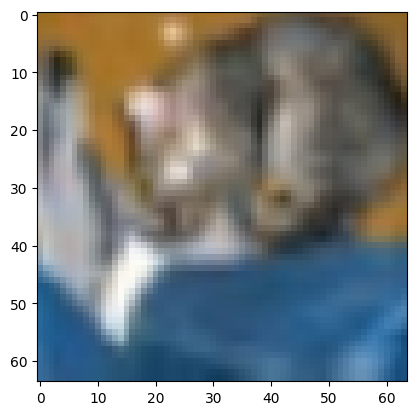

In [7]:
dataiter = iter(testload)
sample, label = next(dataiter)

plt.imshow(np.transpose(torch.clamp(transformUnnormalize(sample), 0, 1).squeeze(0).numpy(), (1, 2, 0)))

print(classes[label])

#### DeepFool

Text(0.5, 1.0, 'Difference (Enhanced)')

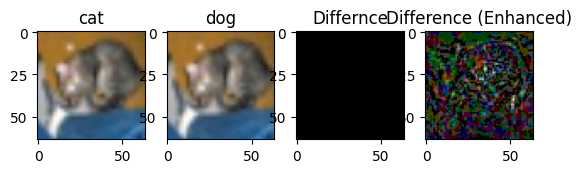

In [8]:
dataiter = iter(testload)
sample, label = next(dataiter)
sample = sample.to(device)
_, _, _, final_pred, perturbedImg = deepfool(sample.squeeze(0), model)


origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

#### FGSM

Text(0.5, 1.0, 'Difference (Enhanced)')

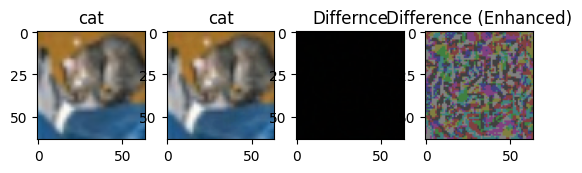

In [9]:
dataiter = iter(testload)
sample, label = next(dataiter)

sample, label = sample.to(device), label.to(device)
sample.requires_grad = True

output = model(sample)
loss = F.nll_loss(output, label)
model.zero_grad()
loss.backward()
data_grad = sample.grad.data
perturbedImg = fgsm_attack(sample, 0.02, data_grad)
output = model(perturbedImg)
final_pred = output.max(1, keepdim=True)[1]

origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

#### JSMA

Text(0.5, 1.0, 'Difference (Enhanced)')

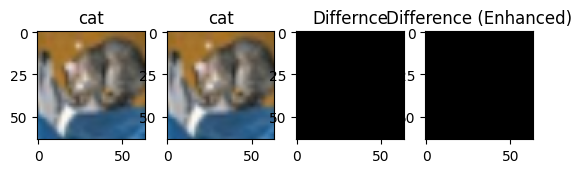

In [10]:
dataiter = iter(testload)
sample, label = next(dataiter)

sample, label = sample.to(device), label.to(device)
sample.requires_grad = True

perturbedImg, final_pred = jsma_attack(model, sample, label)

origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

### Original

In [6]:
model.load_state_dict(trained_weights_cifar10[stateDictNames[nameIdx]])
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [7]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} Original Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet Original Non-perturbed test dataset accuracy = 0.8066


#### DeepFool Dataset

In [8]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.1082


#### FGSM Dataset

In [9]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.5404


#### JSMA Dataset

In [41]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
firstTime = False
timeCounter = 0
idxidx = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1
    elif gtLabelCollection[idx] != perturbedLabelCollection[idx] and firstTime == False:
        idxidx = idx
        if timeCounter < 6:
            timeCounter = timeCounter + 1
        else:
            firstTime = True

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))
idxidx

alexnet Original jsma test dataset accuracy = 0.8059


35

### DeepFool Trained

In [11]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_deepfool.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [12]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} DeepFool Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet DeepFool Trained Non-perturbed test dataset accuracy = 0.8013


#### DeepFool Dataset

In [13]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet DeepFool Trained deepfool test dataset accuracy = 0.7414


#### FGSM Dataset

In [14]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet DeepFool Trained fgsm test dataset accuracy = 0.5991


#### JSMA Dataset

In [15]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet DeepFool Trained jsma test dataset accuracy = 0.8044


### FGSM Trained

In [16]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_fgsm.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [17]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} FGSM Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet FGSM Trained Non-perturbed test dataset accuracy = 0.7975


#### DeepFool Dataset

In [18]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet FGSM Trained deepfool test dataset accuracy = 0.6562


#### FGSM Dataset

In [19]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet FGSM Trained fgsm test dataset accuracy = 0.5818


#### JSMA Dataset

In [20]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet FGSM Trained jsma test dataset accuracy = 0.7961


### JSMA Trained

In [21]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_jsma.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [22]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} JSMA Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet JSMA Trained Non-perturbed test dataset accuracy = 0.8068


#### DeepFool Dataset

In [23]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet JSMA Trained deepfool test dataset accuracy = 0.4627


#### FGSM Dataset

In [24]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet JSMA Trained fgsm test dataset accuracy = 0.5405


#### JSMA Dataset

In [25]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet JSMA Trained jsma test dataset accuracy = 0.8042


## GoogLeNet

In [11]:
model = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1)
num_feats = model.fc.in_features
model.fc = nn.Linear(num_feats, 10)
nameIdx = 1

### Example Images

In [12]:
model.load_state_dict(trained_weights_cifar10[stateDictNames[nameIdx]])
model.to(device)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

#### Original

cat


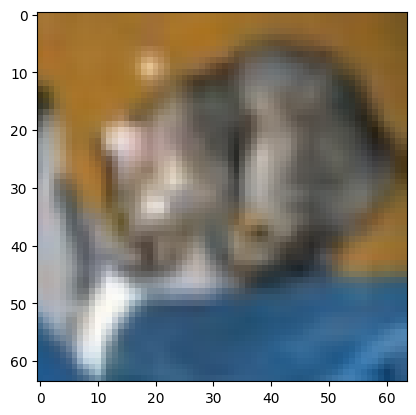

In [13]:
dataiter = iter(testload)
sample, label = next(dataiter)

plt.imshow(np.transpose(torch.clamp(transformUnnormalize(sample), 0, 1).squeeze(0).numpy(), (1, 2, 0)))

print(classes[label])

#### DeepFool

Text(0.5, 1.0, 'Difference (Enhanced)')

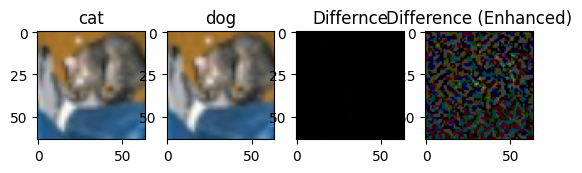

In [14]:
dataiter = iter(testload)
sample, label = next(dataiter)
sample = sample.to(device)
_, _, _, final_pred, perturbedImg = deepfool(sample.squeeze(0), model)

origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

#### FGSM

Text(0.5, 1.0, 'Difference (Enhanced)')

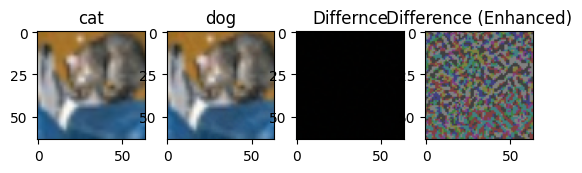

In [15]:
dataiter = iter(testload)
sample, label = next(dataiter)

sample, label = sample.to(device), label.to(device)
sample.requires_grad = True

output = model(sample)
loss = F.nll_loss(output, label)
model.zero_grad()
loss.backward()
data_grad = sample.grad.data
perturbedImg = fgsm_attack(sample, 0.02, data_grad)
output = model(perturbedImg)
final_pred = output.max(1, keepdim=True)[1]

origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

#### JSMA

Text(0.5, 1.0, 'Difference (Enhanced)')

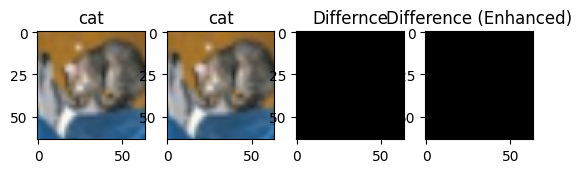

In [16]:
dataiter = iter(testload)
sample, label = next(dataiter)

sample, label = sample.to(device), label.to(device)
sample.requires_grad = True

perturbedImg, final_pred = jsma_attack(model, sample, label)

origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

### Original

In [ ]:
model.load_state_dict(trained_weights_cifar10[stateDictNames[nameIdx]])
model.to(device)
model.eval()

#### Normal Dataset

In [2]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} Original Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

NameError: name 'testload' is not defined

#### DeepFool Dataset

In [ ]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.1082


#### FGSM Dataset

In [ ]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.5404


#### JSMA Dataset

In [ ]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original jsma test dataset accuracy = 0.8059


### DeepFool Trained

In [ ]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_deepfool.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [ ]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} DeepFool Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet Original Non-perturbed test dataset accuracy = 0.805


#### DeepFool Dataset

In [ ]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.7159


#### FGSM Dataset

In [ ]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.6005


#### JSMA Dataset

In [ ]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original jsma test dataset accuracy = 0.8056


### FGSM Trained

In [ ]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_fgsm.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [ ]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} FGSM Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet Original Non-perturbed test dataset accuracy = 0.7951


#### DeepFool Dataset

In [ ]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.6398


#### FGSM Dataset

In [ ]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.5822


#### JSMA Dataset

In [ ]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original jsma test dataset accuracy = 0.7931


### JSMA Trained

In [ ]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_jsma.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [ ]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} JSMA Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet Original Non-perturbed test dataset accuracy = 0.803


#### DeepFool Dataset

In [ ]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.4703


#### FGSM Dataset

In [ ]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.5374


#### JSMA Dataset

In [ ]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

## Mobilenet V3 Large

In [17]:
model = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
num_feat = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_feat, 10)
nameIdx = 2

### Example Images

In [18]:
model.load_state_dict(trained_weights_cifar10[stateDictNames[nameIdx]])
model.to(device)
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

#### Original

cat


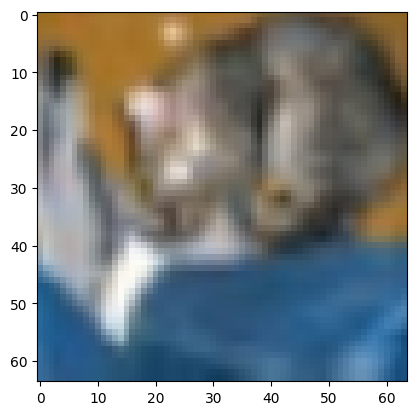

In [19]:
dataiter = iter(testload)
sample, label = next(dataiter)

plt.imshow(np.transpose(torch.clamp(transformUnnormalize(sample), 0, 1).squeeze(0).numpy(), (1, 2, 0)))

print(classes[label])

#### DeepFool

Text(0.5, 1.0, 'Difference (Enhanced)')

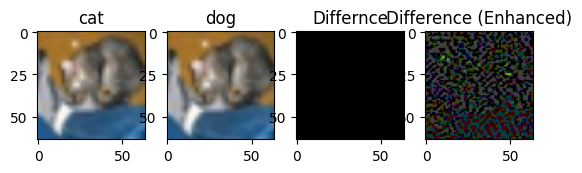

In [20]:
dataiter = iter(testload)
sample, label = next(dataiter)
sample = sample.to(device)
_, _, _, final_pred, perturbedImg = deepfool(sample.squeeze(0), model)

origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

#### FGSM

Text(0.5, 1.0, 'Difference (Enhanced)')

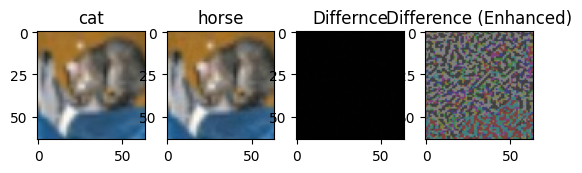

In [21]:
dataiter = iter(testload)
sample, label = next(dataiter)

sample, label = sample.to(device), label.to(device)
sample.requires_grad = True

output = model(sample)
loss = F.nll_loss(output, label)
model.zero_grad()
loss.backward()
data_grad = sample.grad.data
perturbedImg = fgsm_attack(sample, 0.02, data_grad)
output = model(perturbedImg)
final_pred = output.max(1, keepdim=True)[1]

origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

#### JSMA

Text(0.5, 1.0, 'Difference (Enhanced)')

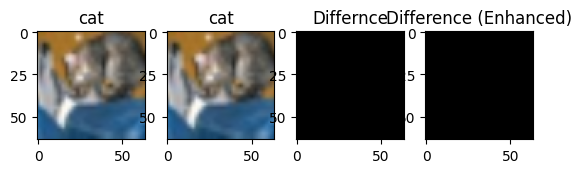

In [22]:
dataiter = iter(testload)
sample, label = next(dataiter)

sample, label = sample.to(device), label.to(device)
sample.requires_grad = True

perturbedImg, final_pred = jsma_attack(model, sample, label)

origImg = transformPIL(torch.clamp(transformUnnormalize(sample.cpu().squeeze(0)), 0, 1))
pertImg = transformPIL(torch.clamp(transformUnnormalize(perturbedImg.cpu()), 0, 1).squeeze(0))

fig, axs = plt.subplots(1,4)
axs[0].imshow(origImg)
axs[0].set_title(classes[label])

axs[1].imshow(pertImg)
axs[1].set_title(classes[final_pred])

diffImg = ImageChops.difference(pertImg, origImg)
axs[2].imshow(diffImg)
axs[2].set_title("Differnce")

enhancer = ImageEnhance.Brightness(ImageChops.difference(pertImg, origImg))
brighterImage = enhancer.enhance(64)
axs[3].imshow(brighterImage)
axs[3].set_title("Difference (Enhanced)")

### Original

In [ ]:
model.load_state_dict(trained_weights_cifar10[stateDictNames[nameIdx]])
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [ ]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} Original Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet Original Non-perturbed test dataset accuracy = 0.8021


#### DeepFool Dataset

In [ ]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.1082


#### FGSM Dataset

In [ ]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.5404


#### JSMA Dataset

In [ ]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

count = 0
for idx in range(len(gtLabelCollection)):
    if gtLabelCollection[idx] == perturbedLabelCollection[idx]:
        count = count + 1

print("{} Original {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original jsma test dataset accuracy = 0.8059


### DeepFool Trained

In [ ]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_deepfool.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [ ]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} DeepFool Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet Original Non-perturbed test dataset accuracy = 0.805


#### DeepFool Dataset

In [ ]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.7159


#### FGSM Dataset

In [ ]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.6005


#### JSMA Dataset

In [ ]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} DeepFool Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original jsma test dataset accuracy = 0.8056


### FGSM Trained

In [ ]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_fgsm.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [ ]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} FGSM Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet Original Non-perturbed test dataset accuracy = 0.7951


#### DeepFool Dataset

In [ ]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.6398


#### FGSM Dataset

In [ ]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.5822


#### JSMA Dataset

In [ ]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} FGSM Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original jsma test dataset accuracy = 0.7931


### JSMA Trained

In [ ]:
model.load_state_dict(torch.load("models/"+datasetModels[nameIdx]+"_jsma.pt"))
model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Normal Dataset

In [ ]:
count = 0
for sample, label in testload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1
print("{} JSMA Trained Non-perturbed test dataset accuracy = {}".format(datasetModels[nameIdx], count / len(testset)))

alexnet Original Non-perturbed test dataset accuracy = 0.803


#### DeepFool Dataset

In [ ]:
algorithmIdx = 0
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original deepfool test dataset accuracy = 0.4703


#### FGSM Dataset

In [ ]:
algorithmIdx = 1
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))

alexnet Original fgsm test dataset accuracy = 0.5374


#### JSMA Dataset

In [ ]:
algorithmIdx = 2
checkpoint = torch.load("perturbedDataset/"+datasetModels[nameIdx]+"_"+datasetAlgorithm[algorithmIdx]+datasetAppend[1])
perturbedImgCollection = checkpoint["perturbedImgCollection"]
perturbedImgCollection.requires_grad = False
perturbedLabelCollection = checkpoint["perturbedLabelCollection"]
gtLabelCollection = checkpoint["gtLabelCollection"]
gtLabelCollection = gtLabelCollection.long()

customset = CustomDataset(perturbedImgCollection, gtLabelCollection, transform=None)

customload = torch.utils.data.DataLoader(customset, batch_size=batch_size, shuffle=False, num_workers=1)

count = 0
for sample, label in customload:
    sample, label = sample.to(device), label.to(device)
    outputs = model(sample)
    _, preds = torch.max(outputs, 1)
    if preds == label:
        count = count + 1

print("{} JSMA Trained {} test dataset accuracy = {}".format(datasetModels[nameIdx], datasetAlgorithm[algorithmIdx], count / len(testset)))